In [2]:
from hcipy import *
import numpy as np
from matplotlib import pyplot as plt

N = 64
D = 9.96
aperture = circular_aperture(D)
pupil_grid = make_pupil_grid(N, D)
sps = 40 * N // 128
pupsep = 1
outgrid_size = int(np.ceil(sps * (pupsep + 1)))
D_grid = 3.6e-3
pyramid_grid = make_pupil_grid(N, D_grid)
outgrid = np.zeros((N, N)).tolist()
buffer = (N - 2 * outgrid_size)//2

def aberration_basis(N):
    wfref = Wavefront(aperture(pupil_grid))
    wfref.electric_field.shape = (N, N)
    wfrefl = wfref.electric_field.tolist()
    aberration_mode_basis = []
    for i in range(N):
        for j in range(N):
            l = np.zeros((N, N), dtype=complex)
            if np.complex(wfrefl[i][j]) != 0:
                l[i][j] = 1j
                aberration_mode_basis.append(Wavefront(Field(np.round(np.asarray(l).ravel(), 3) * aperture(pupil_grid), wfref.grid)))
    return aberration_mode_basis

basis = aberration_basis(N)

In [3]:
def get_sub_images(electric_field):
    pyramid_grid = make_pupil_grid(N, D_grid)
    images = Field(np.asarray(electric_field).ravel(), pyramid_grid)
    pysize = int(np.sqrt(images.size))
    images.shape = (pysize, pysize)
    sub_images = [images[pysize-sps-1:pysize-1, 0:sps], images[pysize-sps-1:pysize-1, pysize-sps-1:pysize-1],
                  images[0:sps, 0:sps], images[0:sps, pysize-sps-1:pysize-1]]
    subimage_grid = make_pupil_grid(sps, D_grid * sps / N)
    for count, img in enumerate(sub_images):
        img = img.ravel()
        img.grid = subimage_grid
        sub_images[count] = img
    return sub_images

In [4]:
def pyramid_prop(wf):
    # Given a wavefront, returns the result of a pyramid propagation and splitting into sub-images, 
    # as a list of hcipy Field objects.
    keck_pyramid = PyramidWavefrontSensorOptics(pupil_grid, pupil_separation=pupsep, num_pupil_pixels=sps)
    return get_sub_images(keck_pyramid.forward(wf).electric_field)

In [5]:
def estimate(images_list):
    EstimatorObject = PyramidWavefrontSensorEstimator(aperture, make_pupil_grid(sps*2, D_grid*sps*2/N))
    I_b = images_list[0]
    I_a = images_list[1]
    I_c = images_list[2]
    I_d = images_list[3]
    norm = I_a + I_b + I_c + I_d
    I_x = (I_a + I_b - I_c - I_d) / norm
    I_y = (I_a - I_b - I_c + I_d) / norm
    pygrid = make_pupil_grid(sps)
    return Field(I_x.ravel(), pygrid), Field(I_y.ravel(), pygrid)

In [7]:
def make_slopes(wf):
    x, y = estimate(pyramid_prop(wf))
    return np.concatenate((x, y))

In [8]:
slopes_basis = np.asarray([make_slopes(x) for x in basis])

In [9]:
reconstruction = lambda wf: slopes_basis.dot(make_slopes(wf))

In [12]:
def plot_on_aperture(aperture, field):
    project_onto = Wavefront(aperture(pupil_grid)).electric_field
    project_onto.shape = (N, N)

    count, i, j = 0, 0, 0
    while count < len(basis):
        if np.real(project_onto[i][j]) > 0:
            project_onto[i][j] = field[count]
            count += 1
        j += 1
        if j == N - 1:
            j = 0
            i += 1
    return project_onto.ravel() * aperture(pupil_grid)

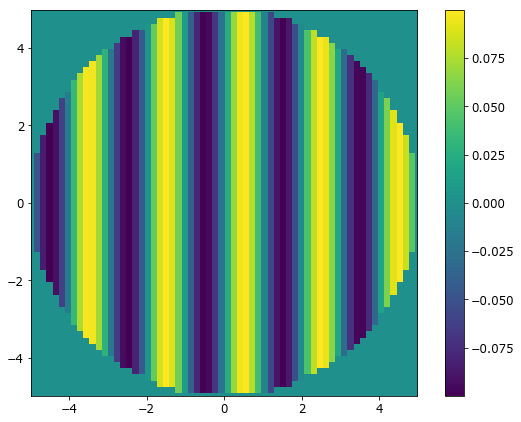

4096


In [13]:
# Expected result: the input and output should be the same. I'm essentially doing a transformation from the pupil-grid
# vector space to the pyramid-grid one, and back.
aberrated = Wavefront(aperture(pupil_grid))
amplitude = 0.1
spatial_frequency = 5
aberrated.electric_field *= np.exp(1j * amplitude * np.sin(2*np.pi * pupil_grid.x / D * spatial_frequency))
imshow_field(aberrated.phase)
plt.colorbar()
plt.show()
print(sum([1 if abs(np.real(el)) < 1e-1 or abs(np.real(el) - 1) < 1e-1 else 0 for el in aberrated.electric_field.tolist()]))


In [ ]:
imshow_field(plot_on_aperture(aperture, Wavefront(Field(reconstruction(aberrated), aberrated.grid)).phase))
plt.colorbar()
plt.show()

In [14]:
def least_inv(A):
    # given a matrix A such that Ax = b, makes a least-squares matrix Y such that
    # x^ = Yb.
    return np.linalg.inv(A.T.dot(A)).dot(A.T)

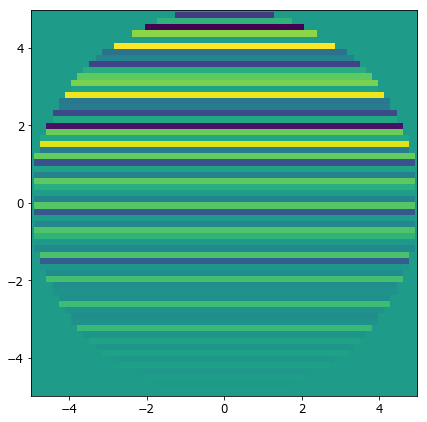

In [32]:
def pupil_sin_phase(pupil, wavsx=1, wavsy=0, amplitude=0.1):
    size=int(np.sqrt(pupil.size))
    x=np.arange(size)
    y=np.arange(size)
    sin = np.zeros((size,size))

    if wavsx==0 and wavsy==0:
        return pupil
    elif wavsy==0:
        yfreq=0
        xfreq = 2*np.pi/((size/wavsx))
    elif wavsx==0:
        xfreq=0
        yfreq = 2*np.pi/((size/wavsy))
    else:
        xfreq = 2*np.pi/((size/wavsx))
        yfreq = 2*np.pi/((size/wavsy))

    for i in range(len(x)):
        for j in range(len(y)):
            sin[i,j] = amplitude*np.sin(xfreq*i+yfreq*j)

    return pupil*np.exp(complex(0,1)*sin).ravel()

wf = Wavefront(aperture(pupil_grid))
imshow_field(pupil_sin_phase(wf.electric_field, N//2, 0).imag)
plt.show()

In [38]:
print(max(pupil_sin_phase(wf.electric_field, 0.1, 0, 0.3).imag.tolist()))

0.17069638947099533


In [34]:
b = (N - 1)//2
aberration_mode_basis = []
for i in range(b):
    aberration_mode_basis.append(pupil_sin_phase(wf.electric_field, i + 1, 0))
for i in range(b):
    aberration_mode_basis.append(pupil_sin_phase(wf.electric_field, 0, i + 1))

In [36]:
len(aberration_mode_basis[0])

4096

In [39]:
# so there are 62 possible aberrations, each corresponding to a 64*64 complex grid. ummmmmm I'm confused. 
# How does this relate to the pyramid output? It doesn't yet, I haven't made the interaction matrix. Now we propagate
# each of these.

pyramid_basis = [make_slopes(Wavefront(x)) for x in aberration_mode_basis]

In [76]:
print(np.asarray(pyramid_basis))

[[ 2.47295269-0.65910589j  2.35867379-0.46286068j  2.28593147-0.42310688j
  ..., -1.40315062+0.65380947j -1.65043662+0.8041793j
  -1.80623300+0.72335931j]
 [ 2.51567123-0.62540906j  2.37611245-0.41512938j  2.27881158-0.33779831j
  ..., -1.38732685+0.67184084j -1.64667297+0.8257423j
  -1.82139960+0.72532468j]
 [ 2.52543486-0.63365238j  2.37977348-0.44505479j  2.27669091-0.35187256j
  ..., -1.39506883+0.66312151j -1.65405534+0.8127763j
  -1.81397372+0.69108527j]
 ..., 
 [ 2.58179144-0.55998622j  2.41753889-0.38768542j  2.32155028-0.34806087j
  ..., -1.39754072+0.71785734j -1.75239783+0.79497575j
  -1.77606179+0.74169966j]
 [ 2.58108521-0.54573712j  2.41981162-0.38017747j  2.31863504-0.36768584j
  ..., -1.40209748+0.66336969j -1.71449513+0.86053604j
  -1.78778063+0.6891547j ]
 [ 2.57701057-0.56522149j  2.41739892-0.37311627j  2.29976384-0.37557266j
  ..., -1.37136461+0.56888282j -1.80350990+0.8918039j
  -1.74112687+0.72055619j]]


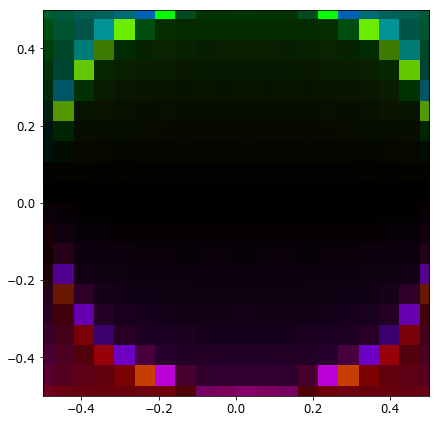

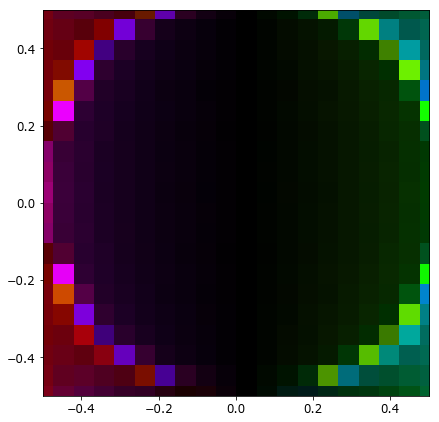

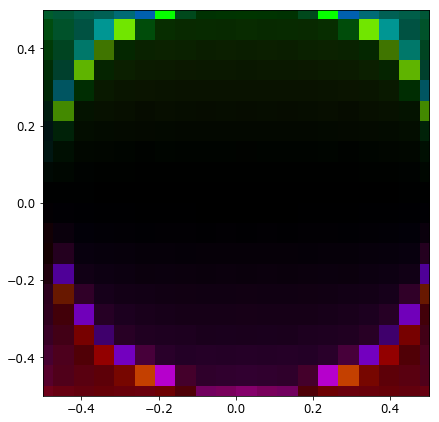

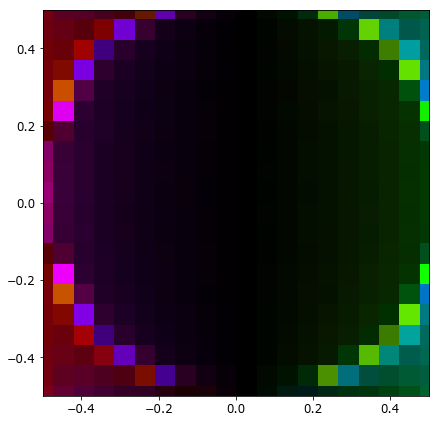

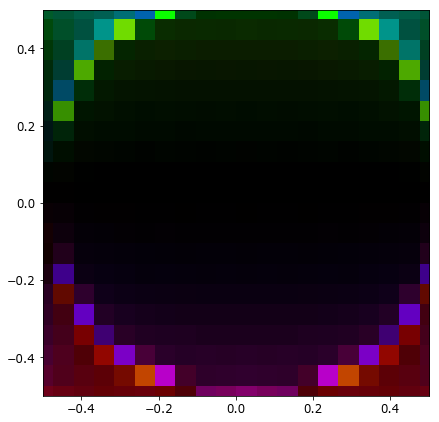

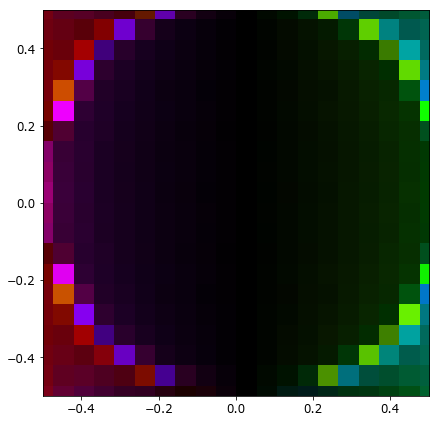

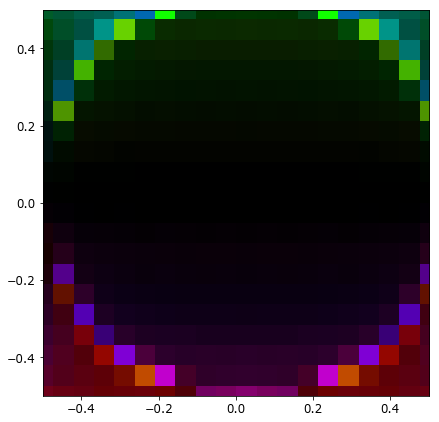

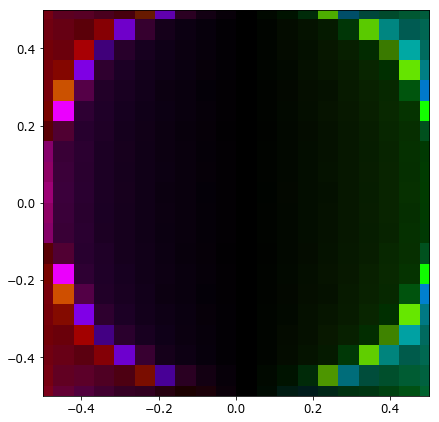

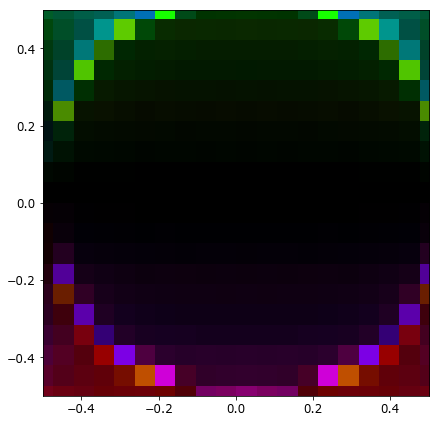

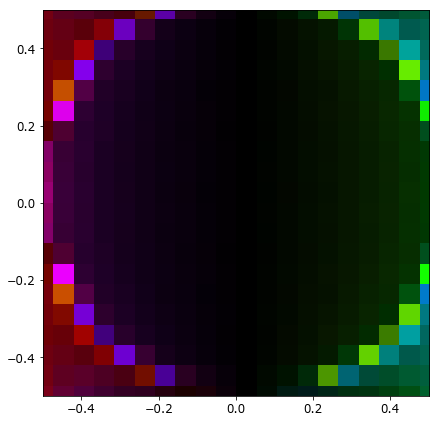

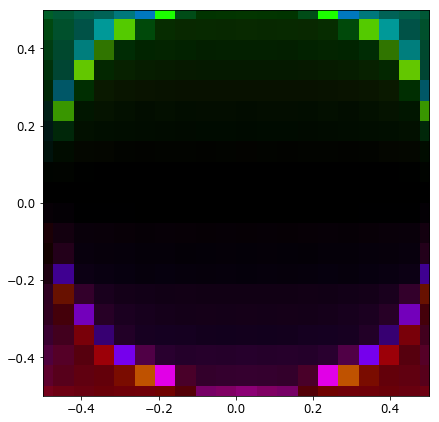

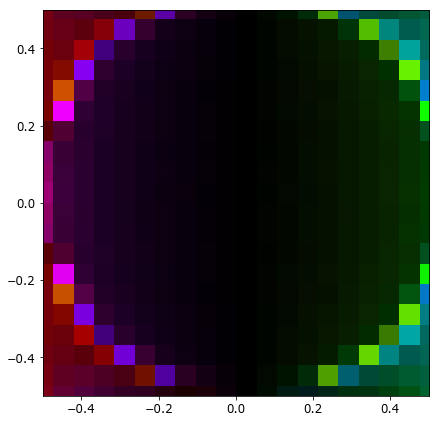

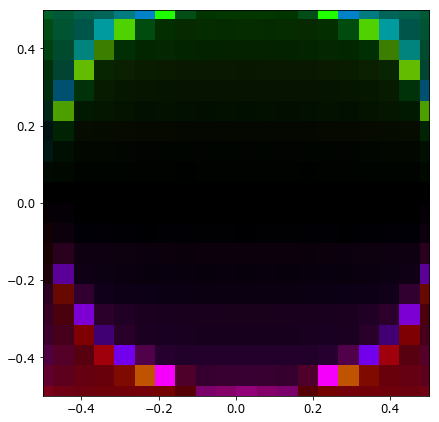

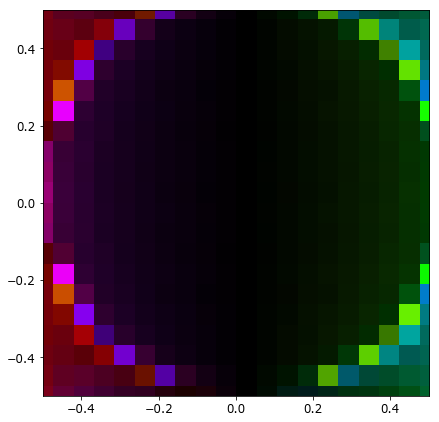

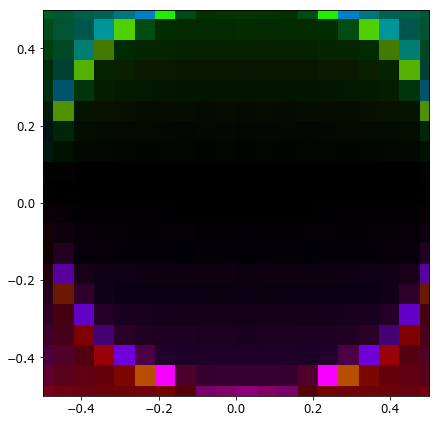

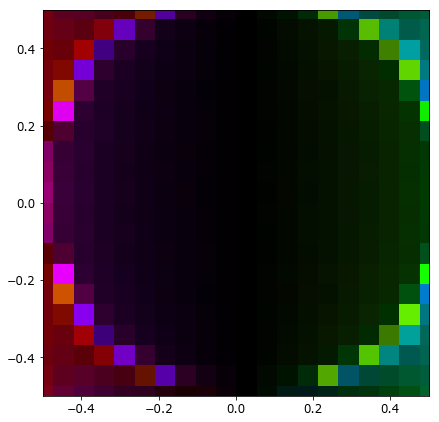

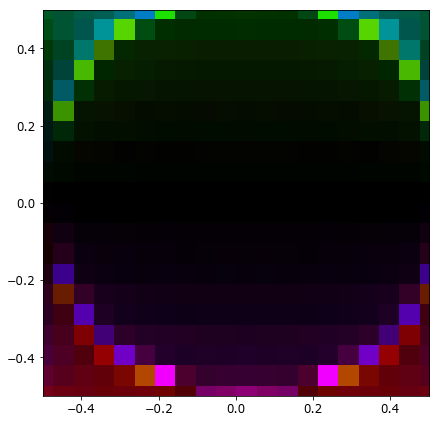

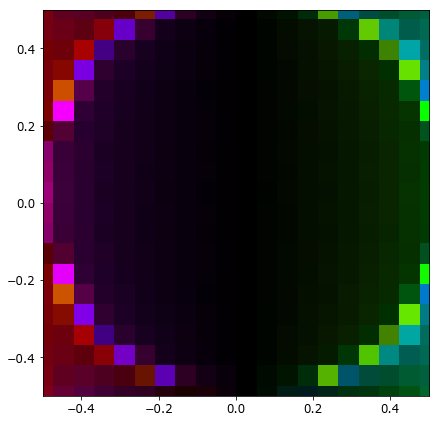

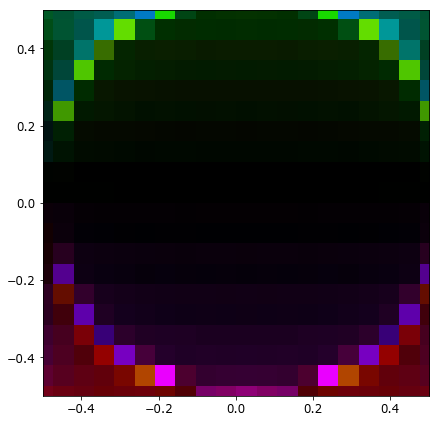

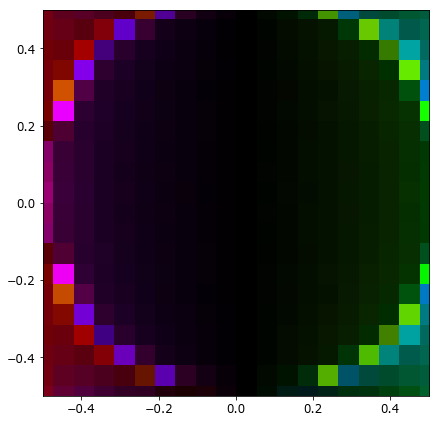

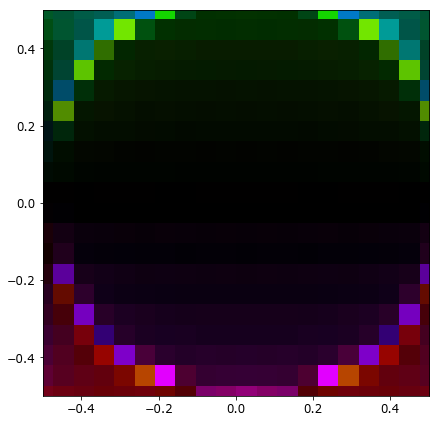

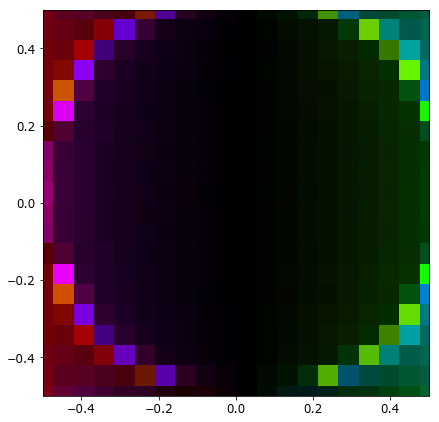

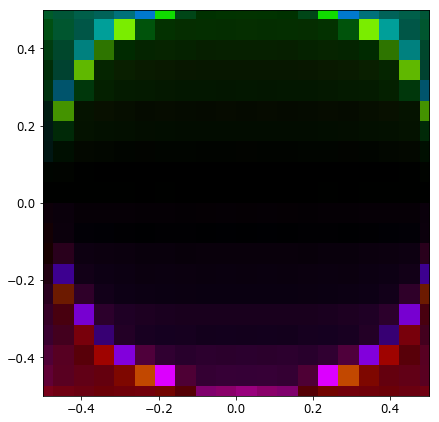

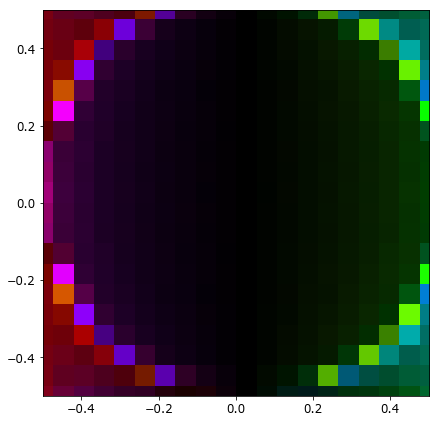

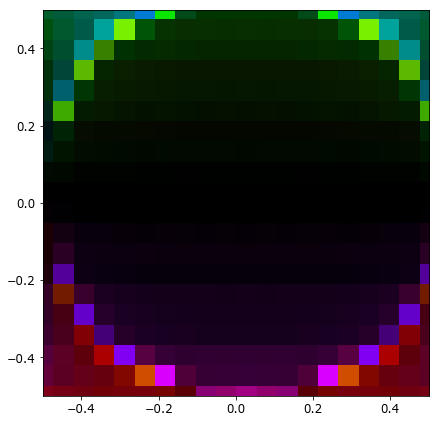

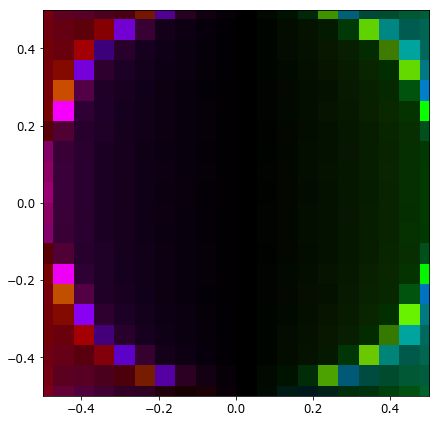

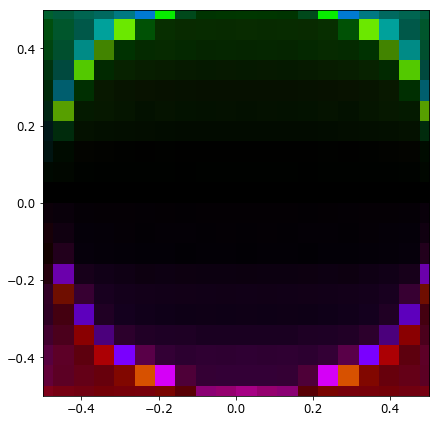

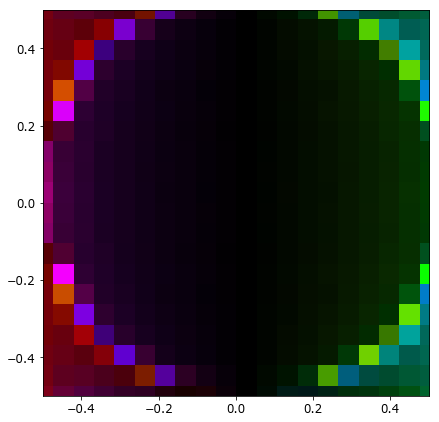

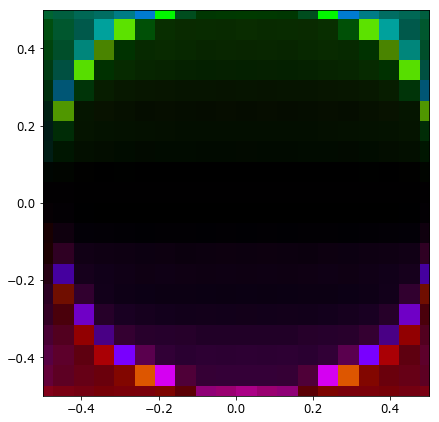

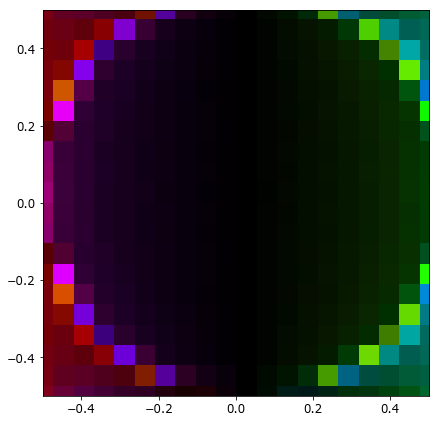

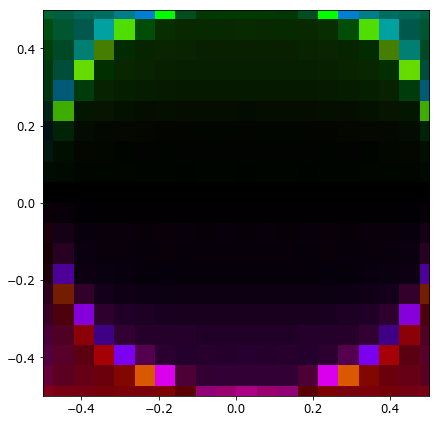

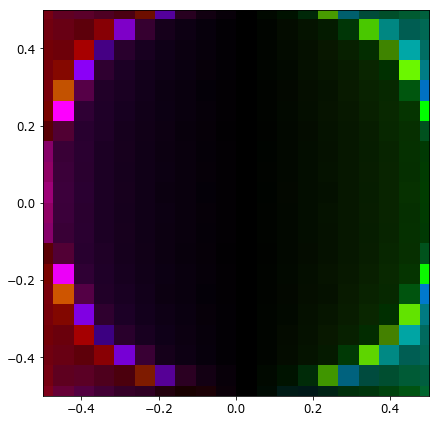

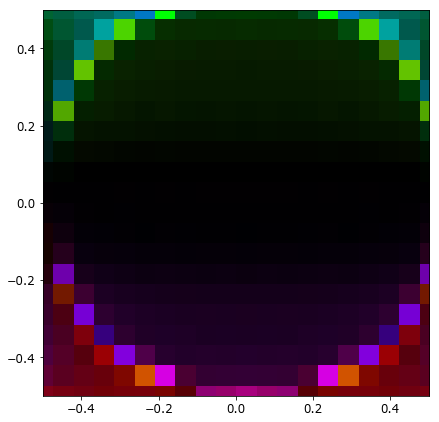

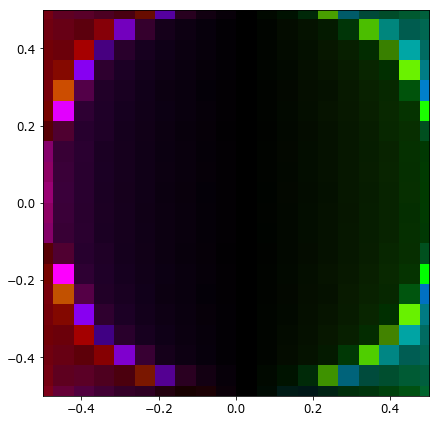

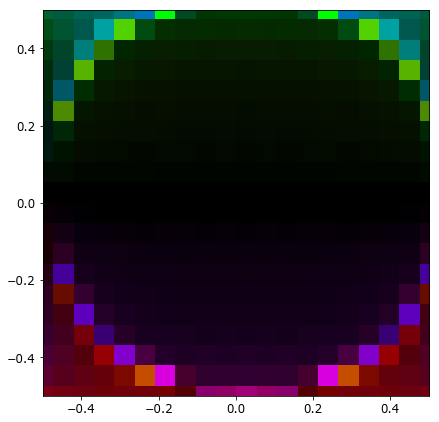

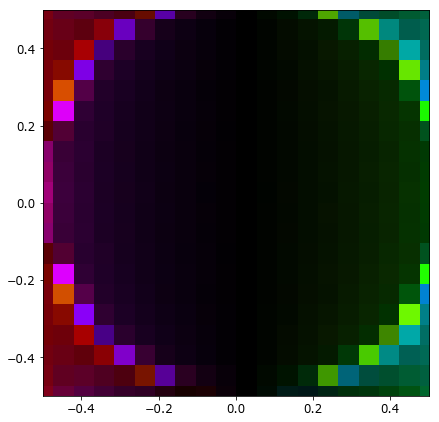

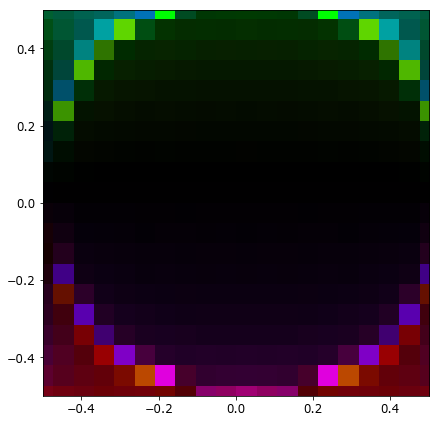

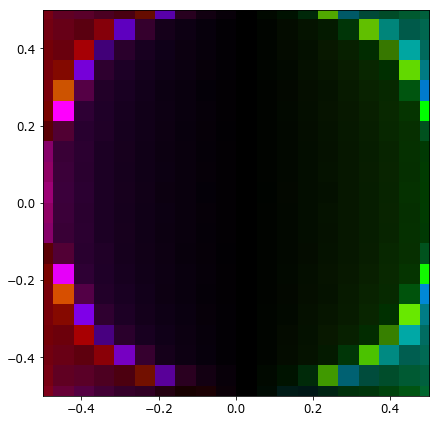

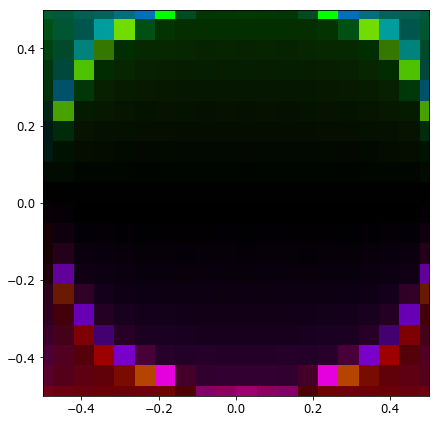

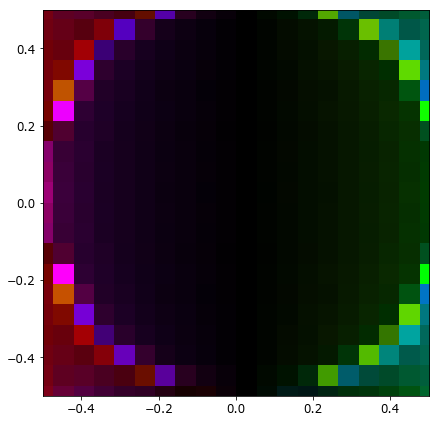

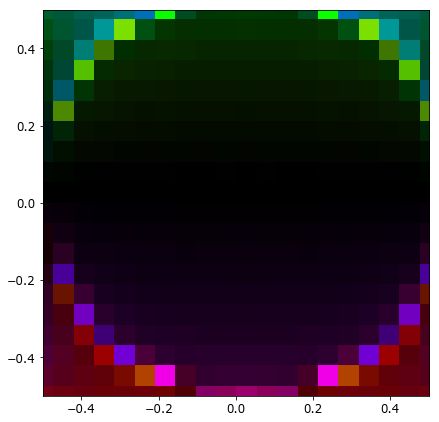

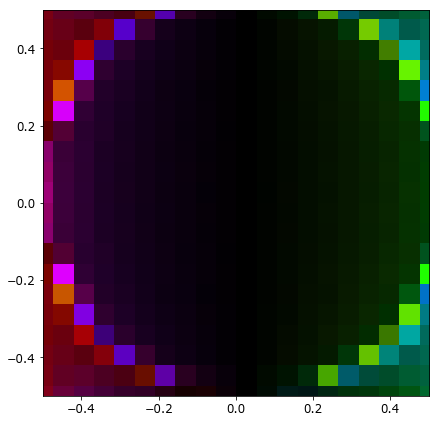

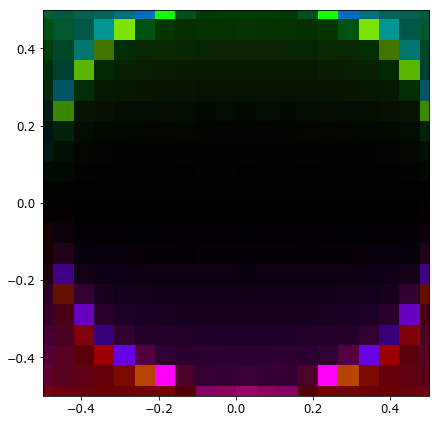

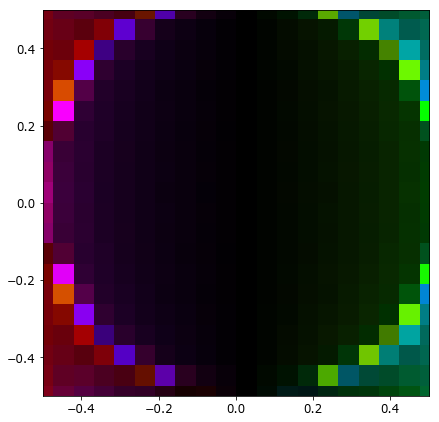

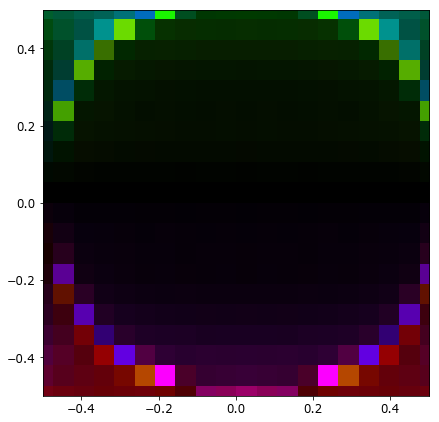

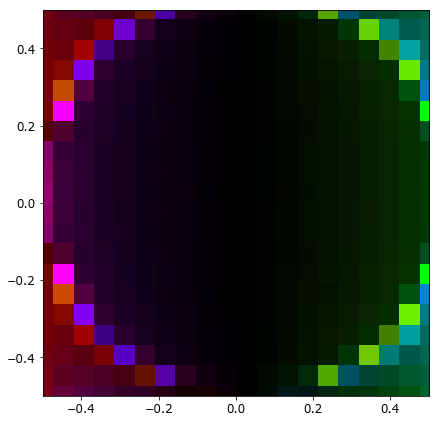

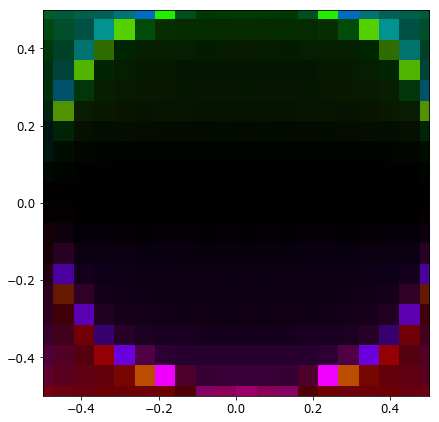

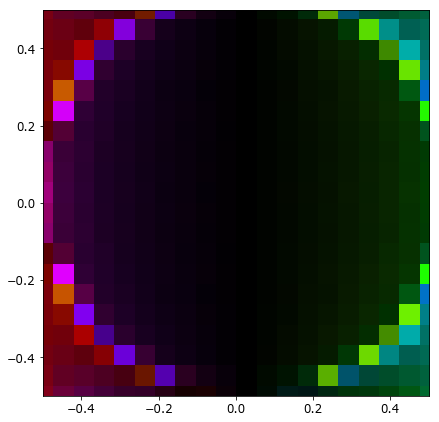

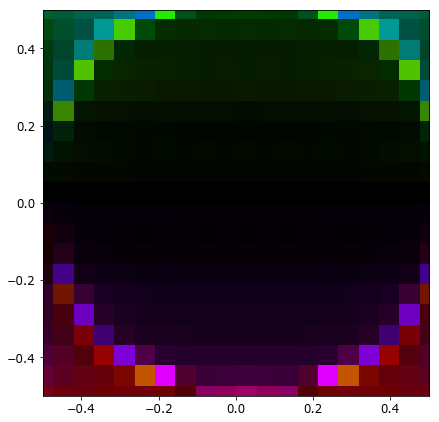

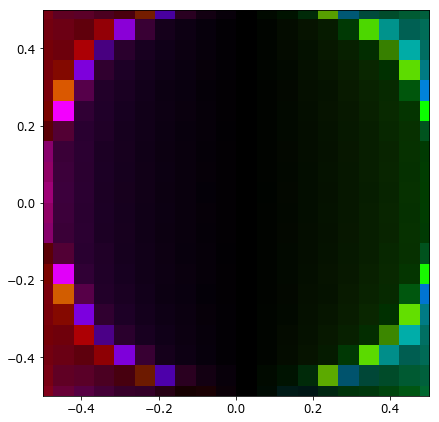

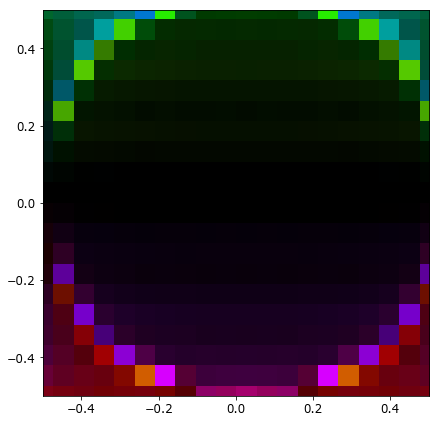

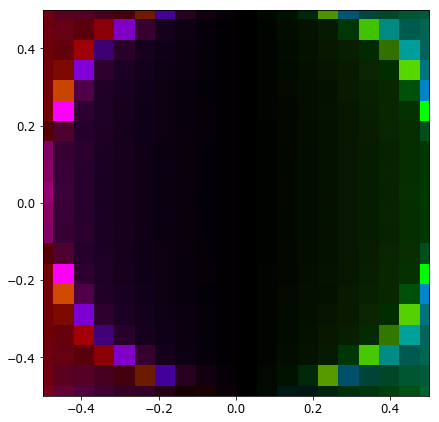

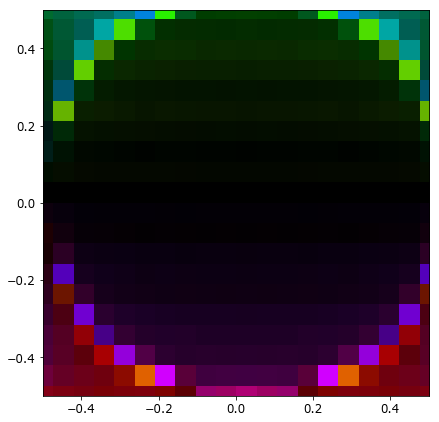

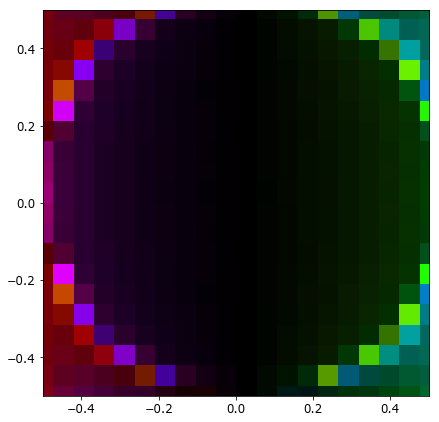

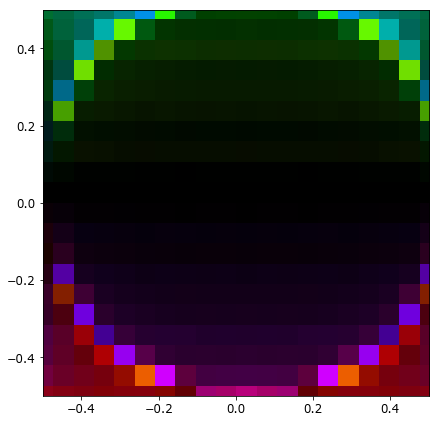

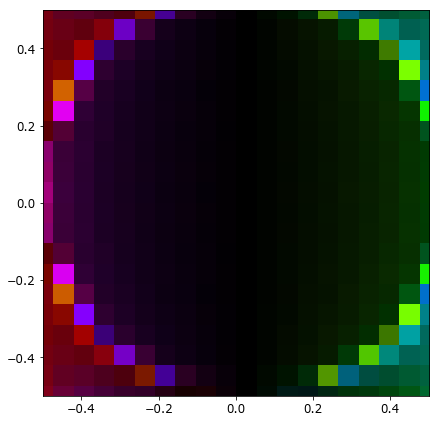

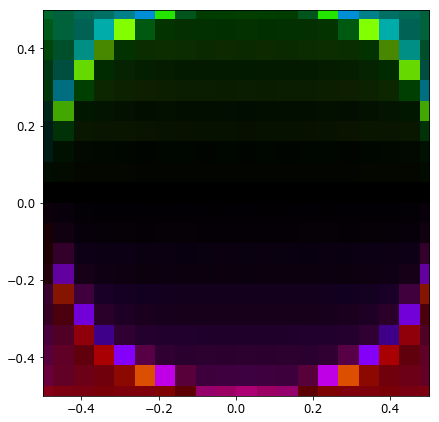

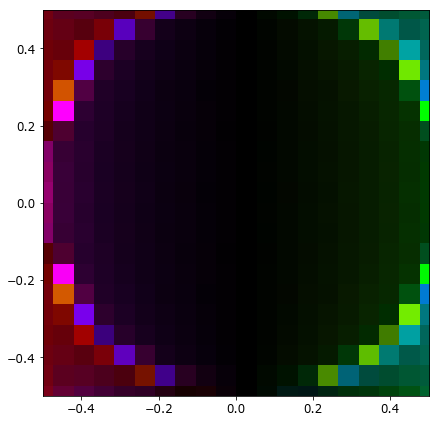

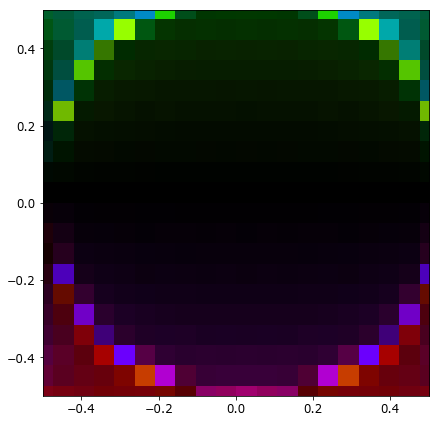

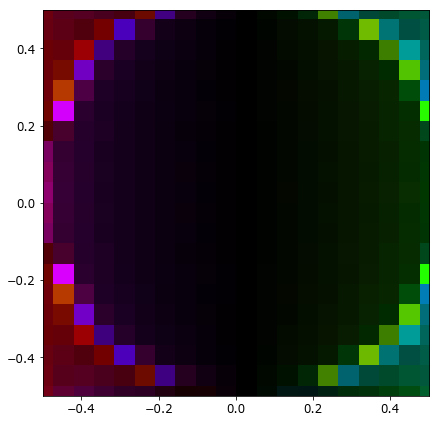

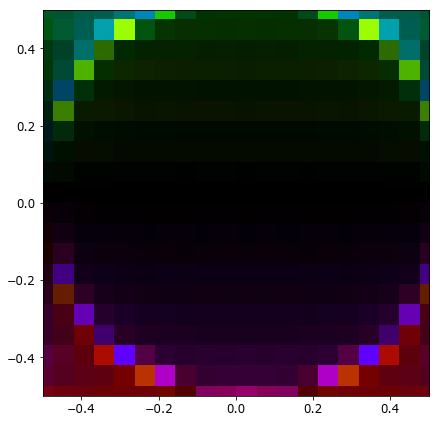

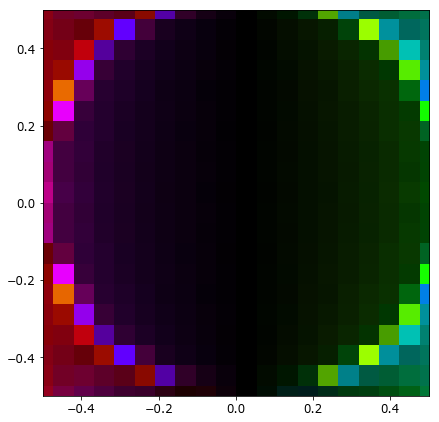

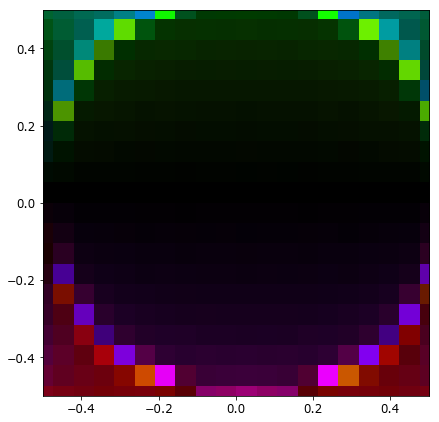

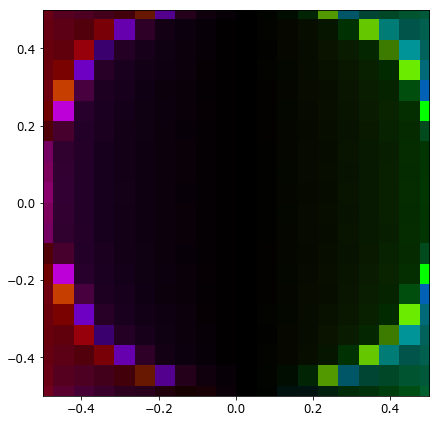

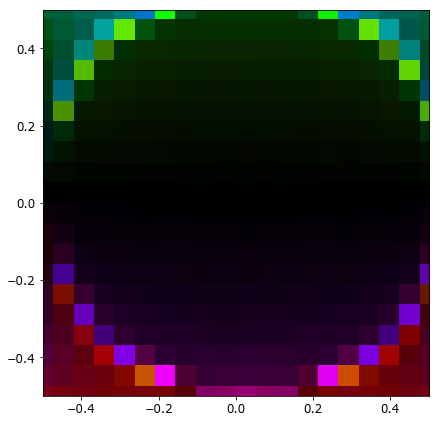

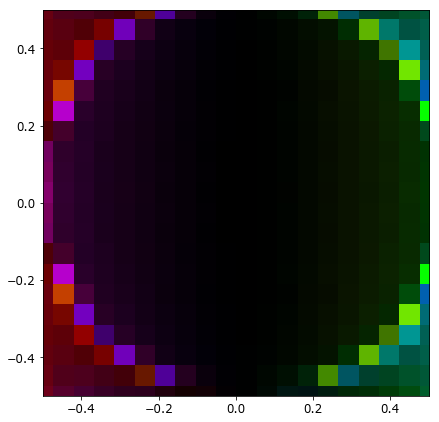

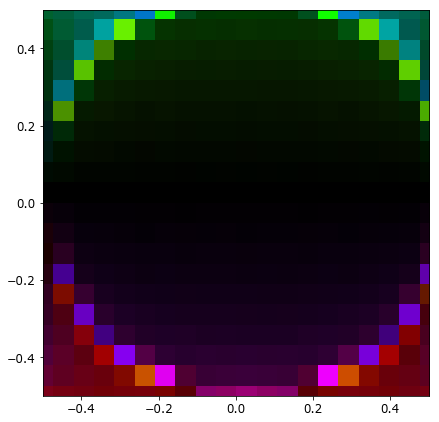

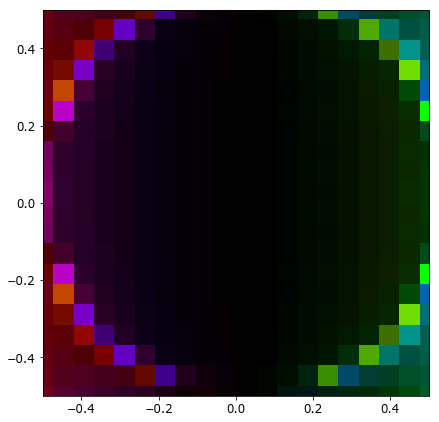

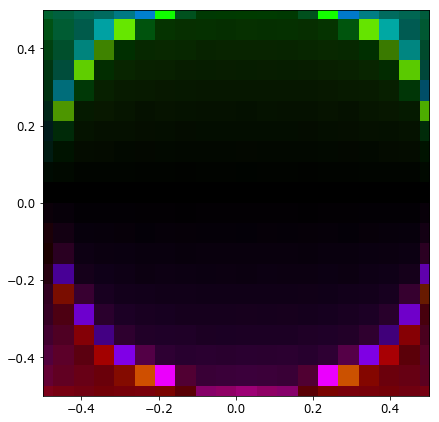

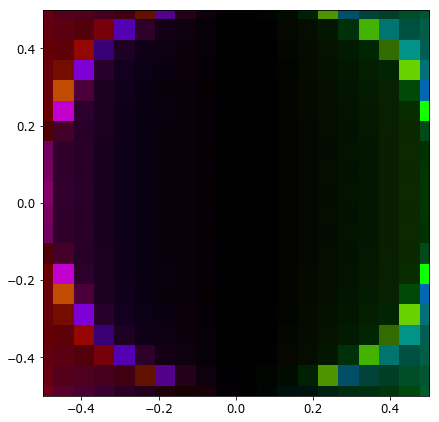

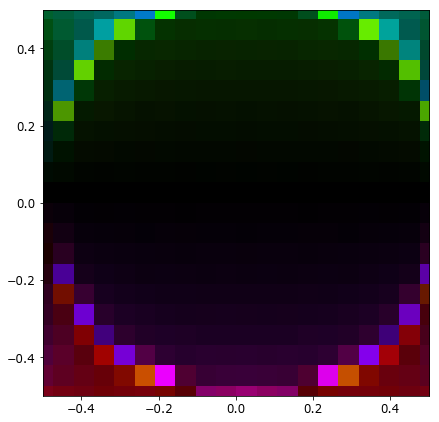

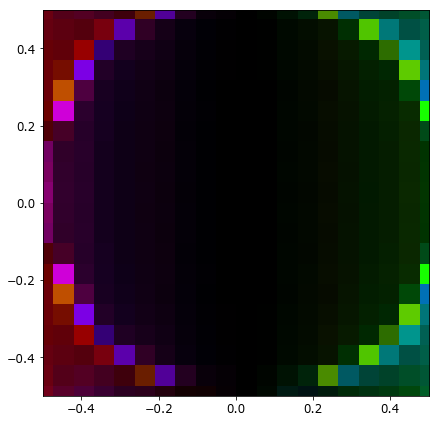

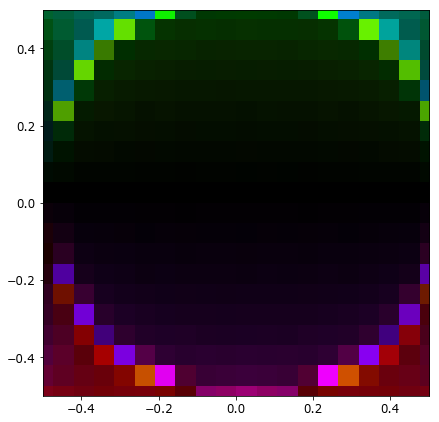

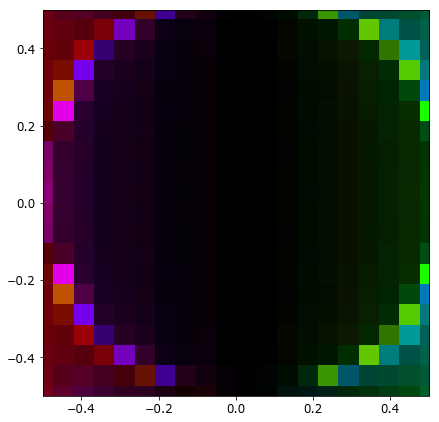

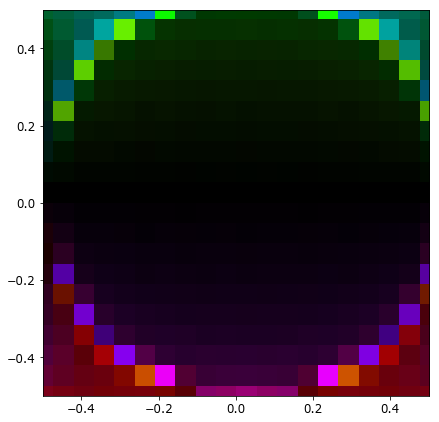

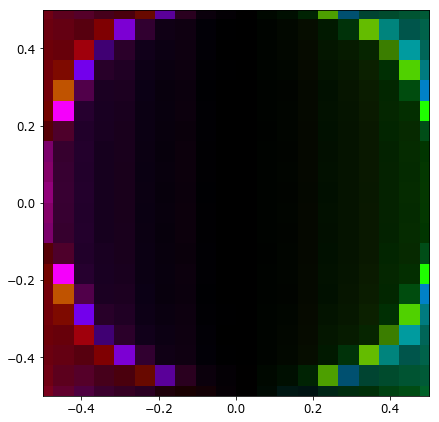

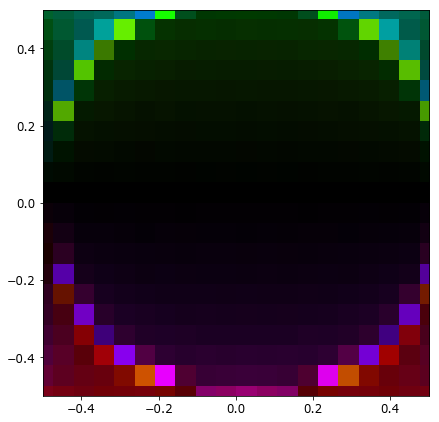

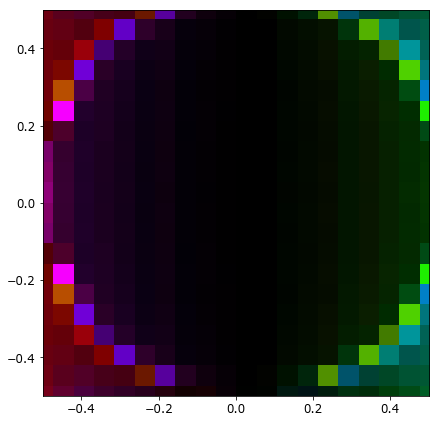

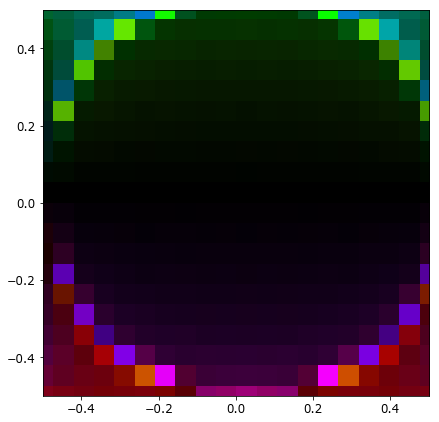

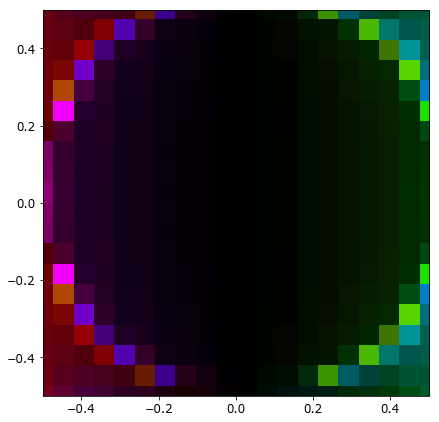

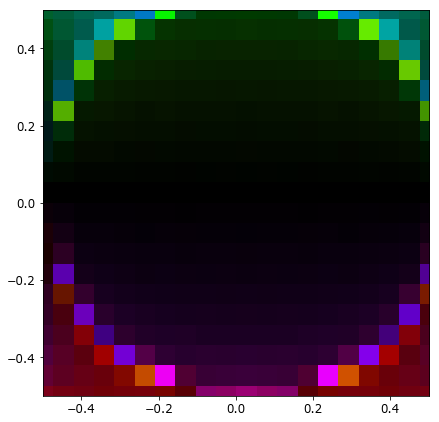

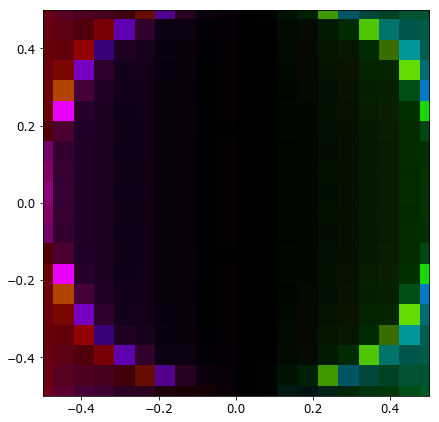

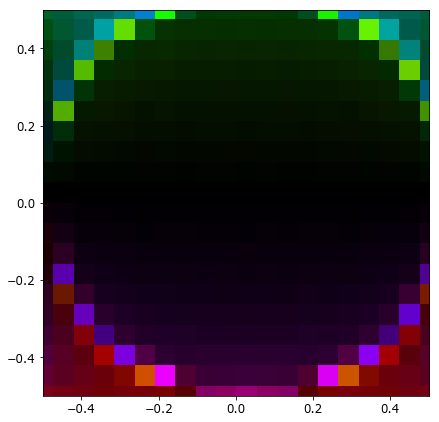

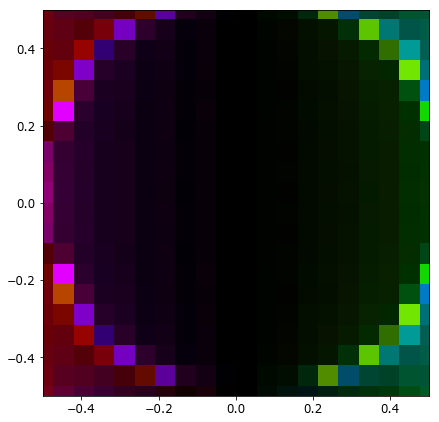

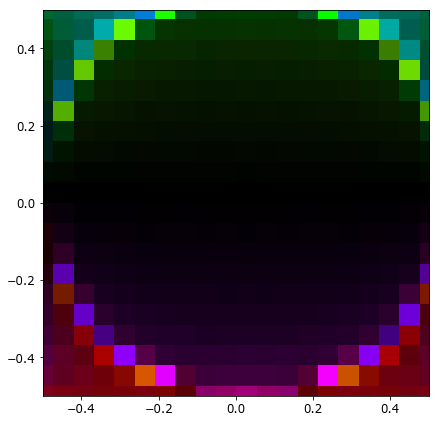

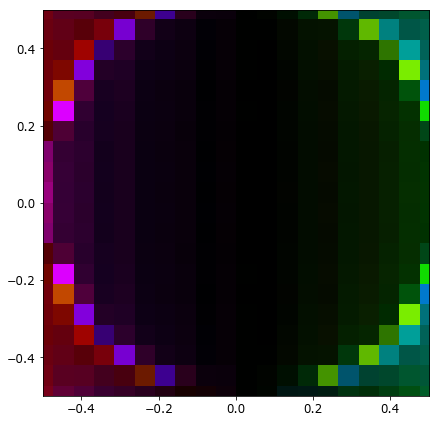

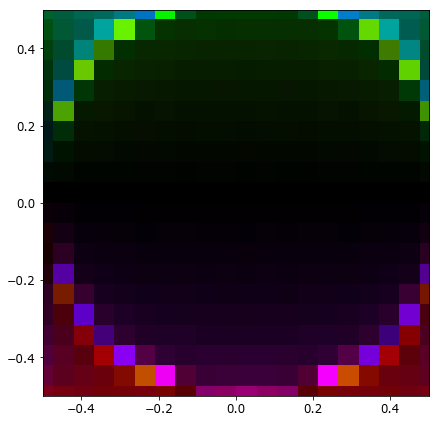

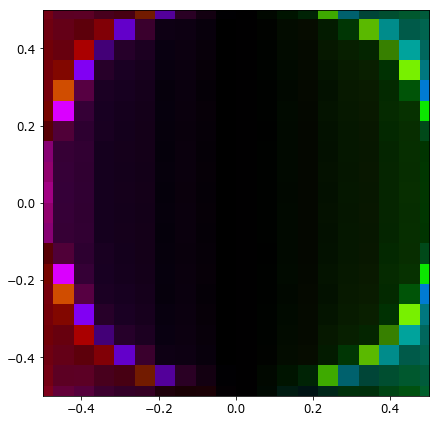

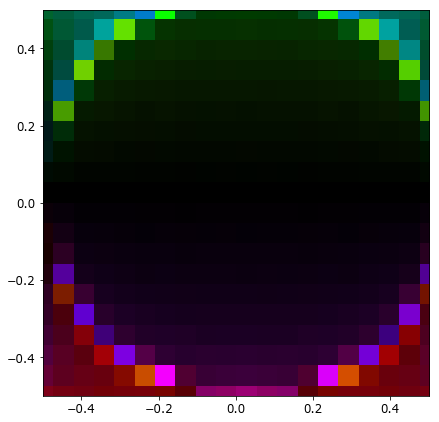

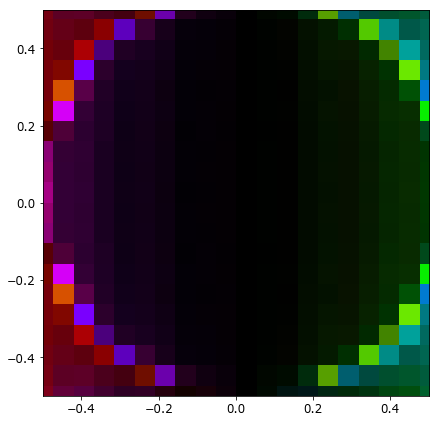

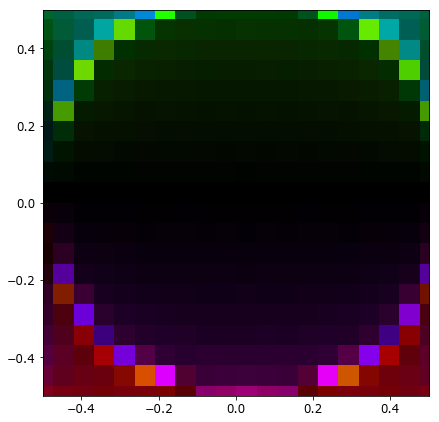

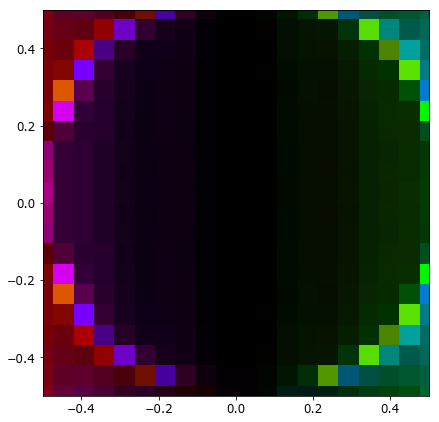

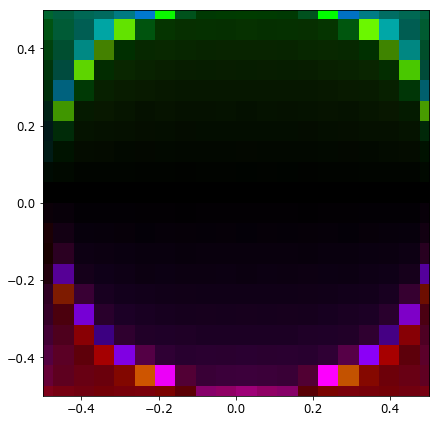

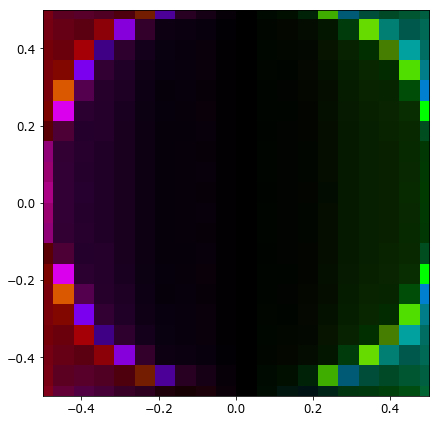

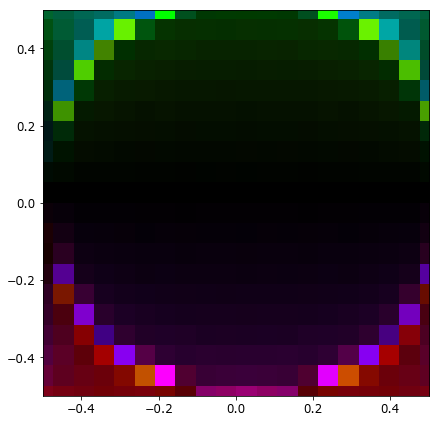

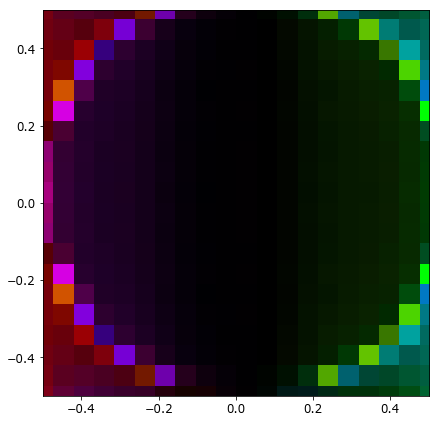

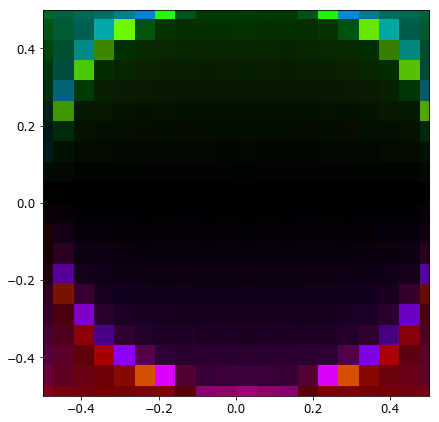

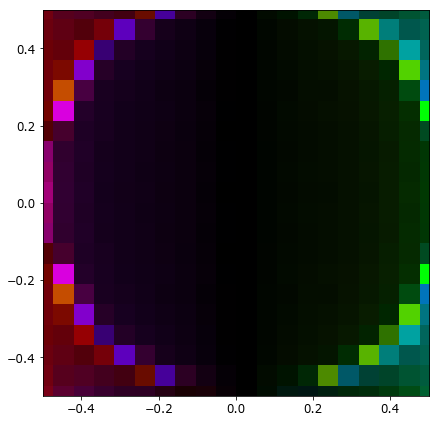

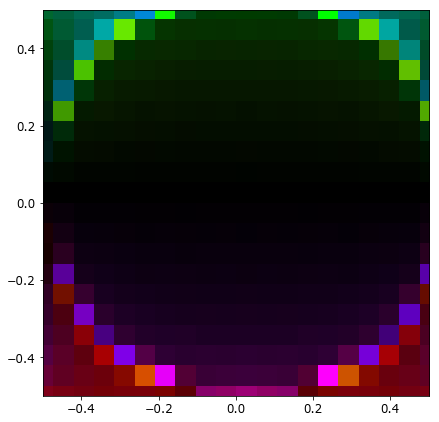

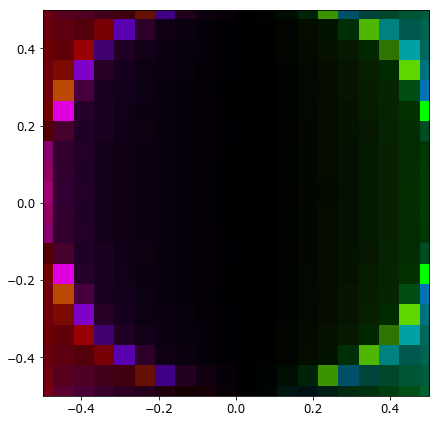

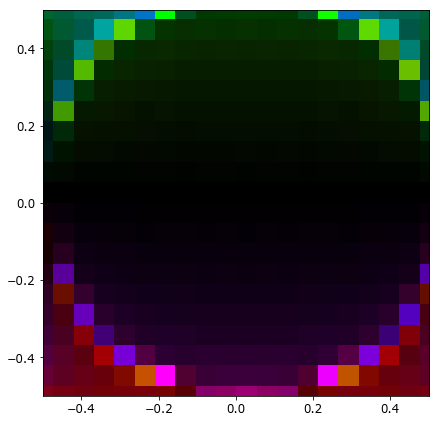

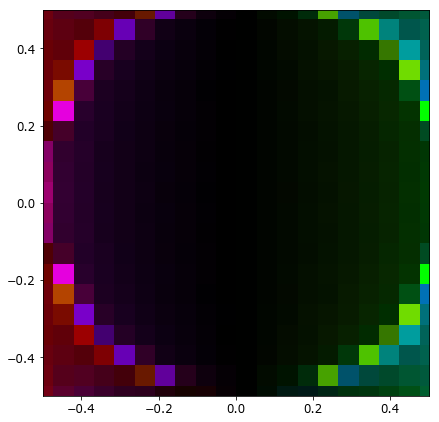

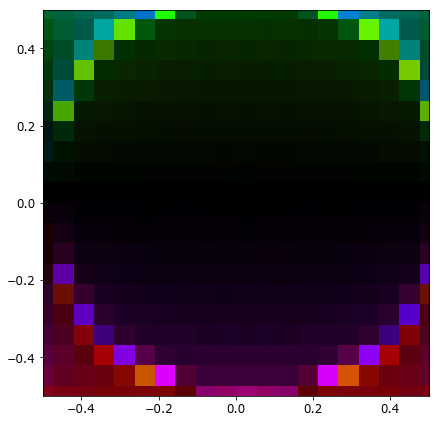

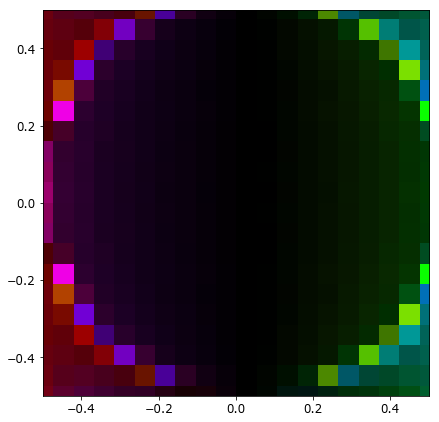

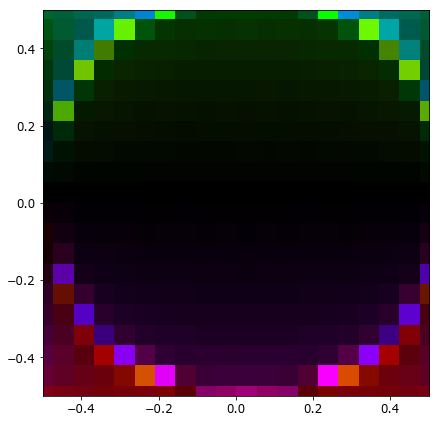

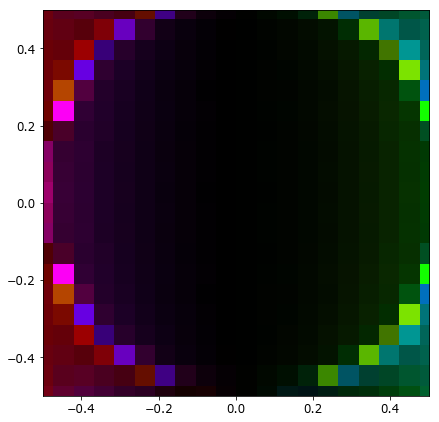

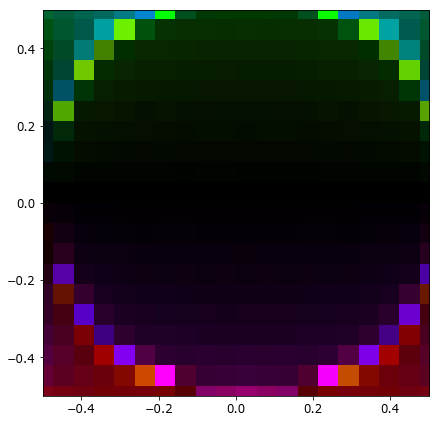

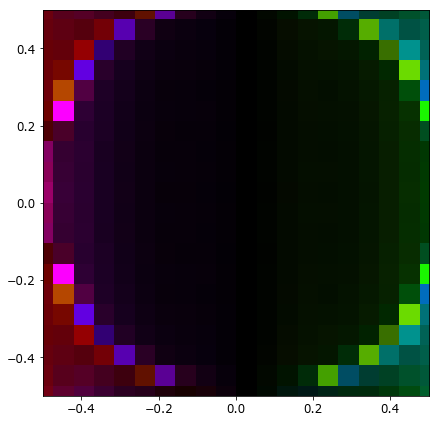

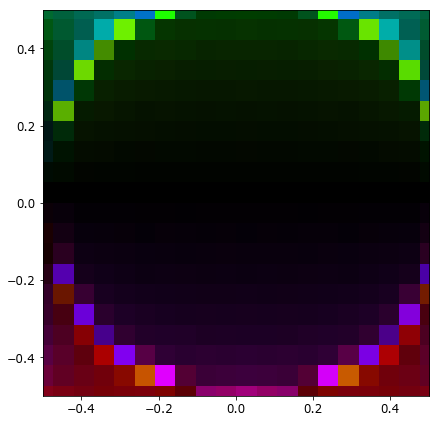

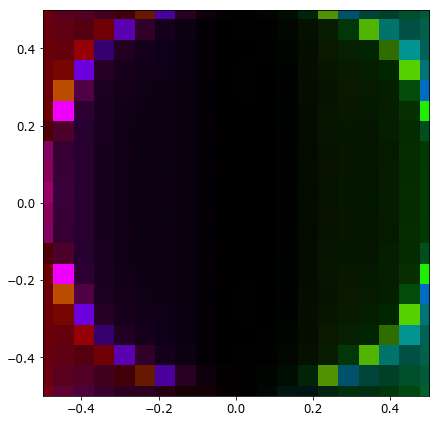

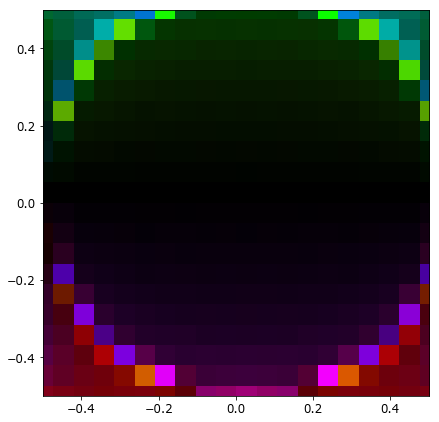

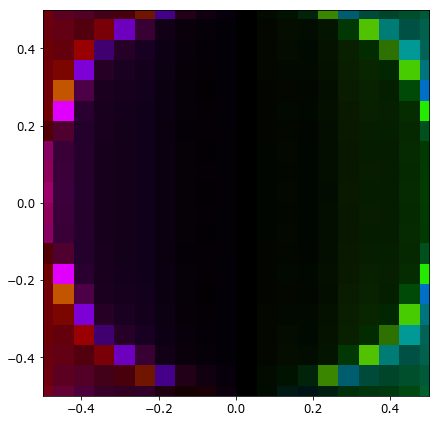

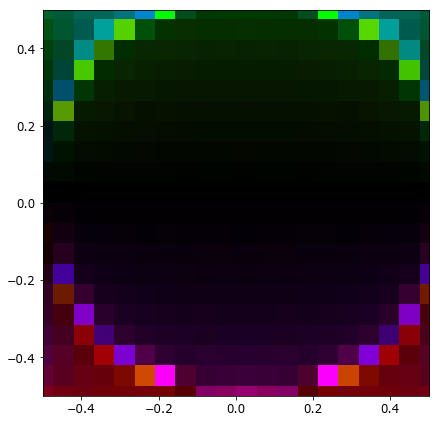

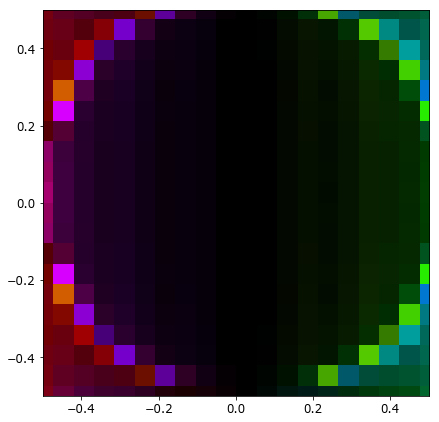

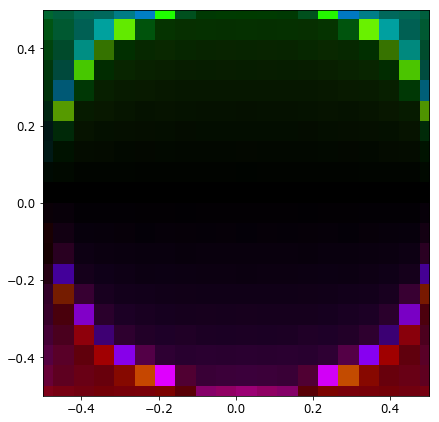

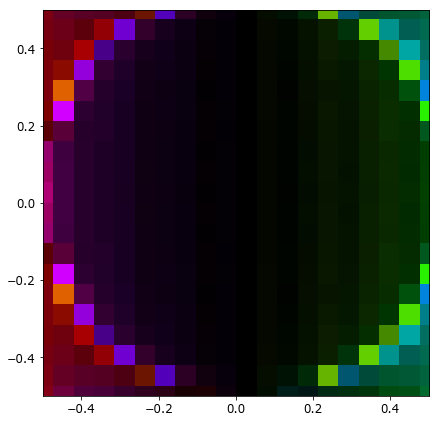

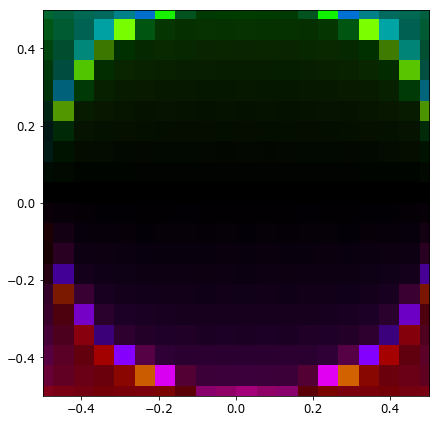

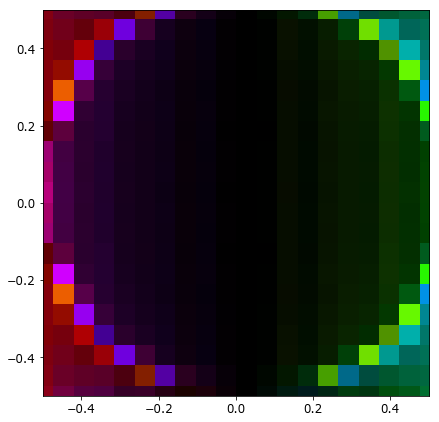

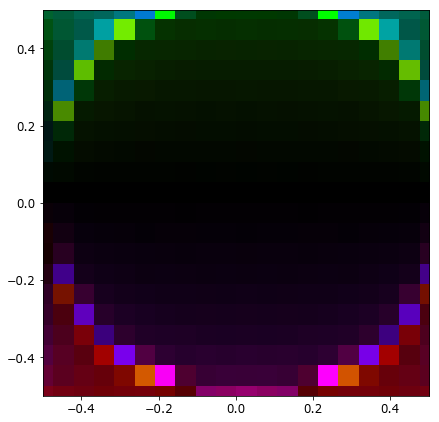

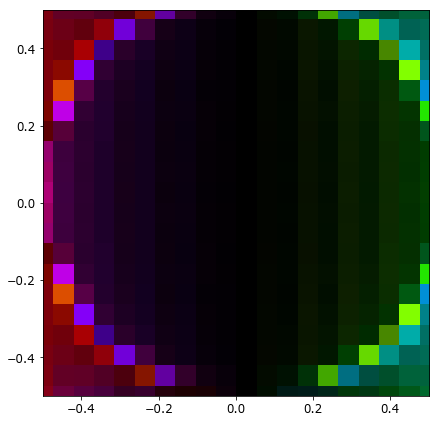

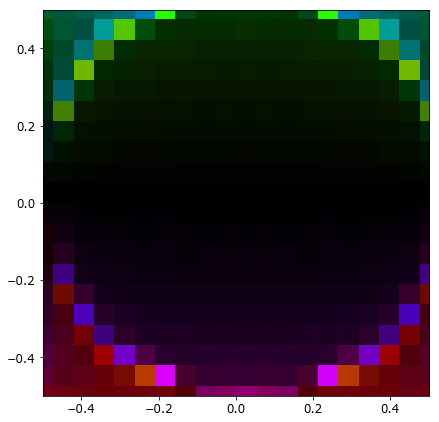

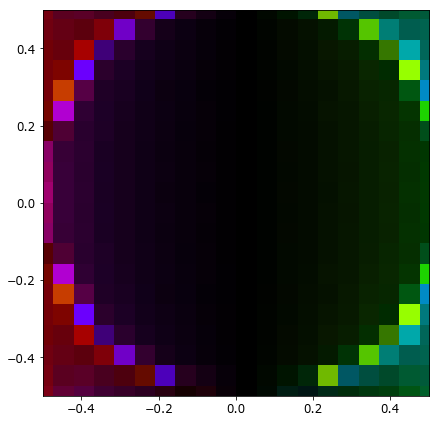

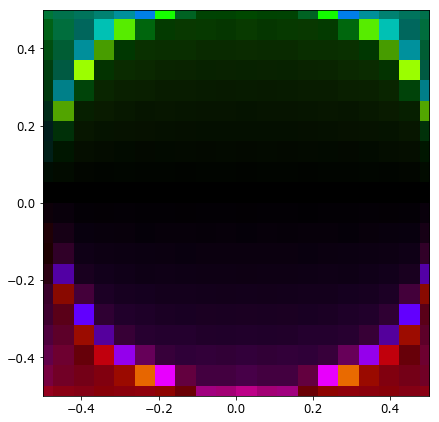

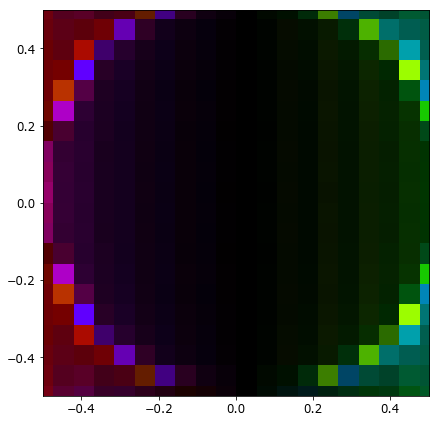

In [48]:
spsg = make_pupil_grid(sps)
for x in pyramid_basis:
    imshow_field(x[0:sps*sps], spsg)
    plt.show()
    imshow_field(x[sps*sps:2*sps*sps], spsg)
    plt.show()

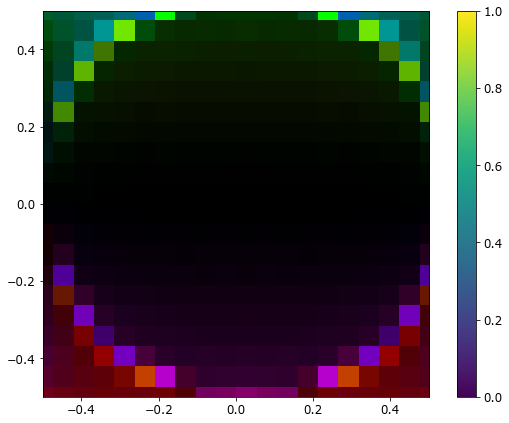

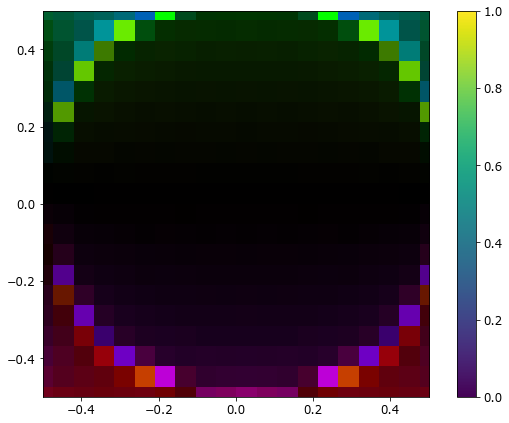

In [57]:
imshow_field(pyramid_basis[1][0:sps*sps], spsg)
plt.colorbar()
plt.show()
imshow_field(pyramid_basis[0][0:sps*sps], spsg)
plt.colorbar()
plt.show()

In [58]:
pyramid_basis = np.asarray(pyramid_basis)

In [88]:
def make_best_sine_approximation(wf):
    return least_inv(np.asarray(aberration_mode_basis)).T.dot(wf.electric_field)

In [60]:
print(type(make_best_sine_approximation(Wavefront(aperture(pupil_grid)))))

LinAlgError: Singular matrix

In [77]:
A = np.asarray(aberration_mode_basis)
print(A.shape)

(62, 4096)


In [82]:
aberration_mode_basis = [x[aperture(pupil_grid) > 0] for x in aberration_mode_basis]
A = np.asarray(aberration_mode_basis)
print(A.shape)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3096 but corresponding boolean dimension is 4096

In [96]:
cleanwf = Wavefront(aperture(pupil_grid)[aperture(pupil_grid) > 0])
make_best_sine_approximation(Wavefront(aberration_mode_basis[0]))

[-1.31965930+0.12741745j  0.95010675+0.45347296j -3.29944121-1.47781897j
 -0.44489167+1.09701072j -1.08277467-1.42717431j -2.31998147-1.83609242j
 -0.79992979+0.13549193j -1.85384285+0.05945135j -1.88514118+1.47931549j
 -2.88425229-1.62141353j -0.21995968-0.34706672j -1.16449505+2.12431561j
 -3.19481583+0.22996567j -1.40154638-1.76563155j -3.11336161+0.67727118j
 -2.22574249-1.04368387j -3.47626517+1.08954451j -1.66952656-1.63883133j
 -2.88449637+0.29836977j -1.52368686+1.8751595j   0.32153806-0.58055384j
 -1.69085377-1.91864201j -2.34182775+2.14753579j -1.69446817+0.08885005j
 -0.59506022+0.28444106j -2.79562051-1.72868443j -1.26044277-0.10134724j
 -0.28788332+0.65070985j -3.70038110-1.42137072j  1.25374228+0.14445623j
 -2.64815819+1.12842093j -1.14980098-1.89154701j -2.46128882-0.27904388j
 -1.61094942+0.06327264j  0.57266986-1.76058241j -1.91711347-0.48304417j
 -1.30843098+1.23890654j  0.60049580+0.46281665j -3.47112544-0.87294965j
 -0.16983734+1.24204556j -1.44220592+1.58159693j -2

In [101]:
(A.T).shape

(3096, 62)

In [103]:
(make_best_sine_approximation(Wavefront(aperture(pupil_grid)[aperture(pupil_grid) > 0]))).shape

(62,)

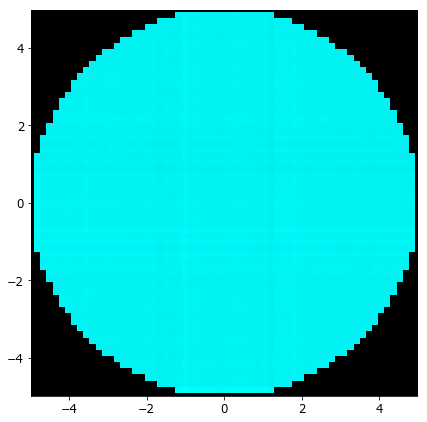

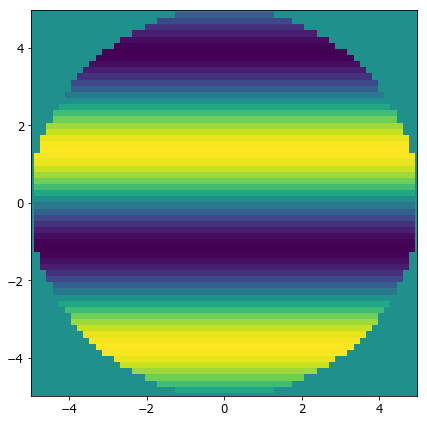

In [117]:
imshow_field(plot_on_aperture(aperture, A.T.dot(make_best_sine_approximation(Wavefront(aberration_mode_basis[1]))).imag))
plt.show()
imshow_field(plot_on_aperture(aperture, aberration_mode_basis[1]).imag)
plt.show()

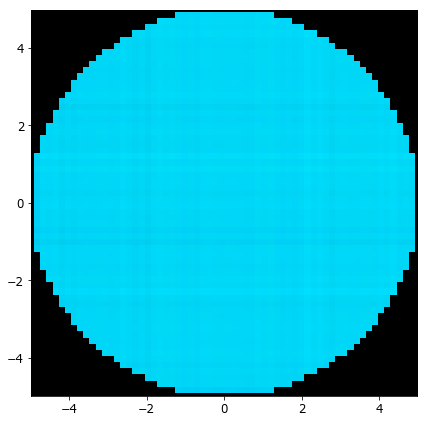

In [110]:
plt.show()